### Verb + Noun → Action Class

In [9]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load Features and Prepare Data
# ------------------------------

features_df = pd.read_csv("..Feature_LocalisationLevel/Feature_S2_Cheese_C1_GTEA_Vgg16.csv")

# Create Mappings for Verb, Noun, and Action Classes
verb_classes = sorted(features_df["Verb_class"].unique())
noun_classes = sorted(features_df["Noun_class"].unique())
action_classes = sorted(features_df["Action_class"].unique())

# Create Mappings for Sequential Indexing
verb_mapping = {verb_classes[i]: i for i in range(len(verb_classes))}
noun_mapping = {noun_classes[i]: i for i in range(len(noun_classes))}
action_mapping = {action_classes[i]: i for i in range(len(action_classes))}

# Apply Mappings to DataFrame
features_df["verb_class_mapped"] = features_df["Verb_class"].map(verb_mapping)
features_df["noun_class_mapped"] = features_df["Noun_class"].map(noun_mapping)
features_df["action_class_mapped"] = features_df["Action_class"].map(action_mapping)

# Split Data into Train, Validation, and Test Sets
train_df, test_df = train_test_split(features_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Process Data Function
# ----------------------

def process_data(df):
    X = torch.tensor(df.iloc[:, 4:].values, dtype=torch.float32)
    verb_labels = torch.tensor(df["verb_class_mapped"].values, dtype=torch.long)
    noun_labels = torch.tensor(df["noun_class_mapped"].values, dtype=torch.long)
    action_labels = torch.tensor(df["action_class_mapped"].values, dtype=torch.long)
    return X, verb_labels, noun_labels, action_labels

# Prepare Data
X_train, y_verb_train, y_noun_train, y_action_train = process_data(train_df)
X_val, y_verb_val, y_noun_val, y_action_val = process_data(val_df)
X_test, y_verb_test, y_noun_test, y_action_test = process_data(test_df)



In [16]:
features_df

,Frame,Verb_class,Noun_class,Action_class,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,...,Feature_6137,Feature_6138,Feature_6139,Feature_6140,Feature_6141,Feature_6142,Feature_6143,verb_class_mapped,noun_class_mapped,action_class_mapped
0,frame_0001.jpg,0,0,0,0.651917,0.407176,0.076979,0.357042,1.976730,0.638776,...,0.155487,0.006345,0.000375,0.108428,0.139510,0.029922,0.226609,0,0,0
1,frame_0006.jpg,0,23,0,0.546664,0.483001,0.135680,0.225158,2.126921,0.551493,...,0.087250,0.241418,0.000000,0.131806,0.069871,0.019073,0.259733,0,5,0
2,frame_0011.jpg,0,23,0,0.483140,0.646575,0.202512,0.355270,2.394428,0.560053,...,0.105661,0.028055,0.000000,0.000000,0.177602,0.010195,0.164882,0,5,0
3,frame_0016.jpg,0,23,0,0.404216,0.568184,0.049507,0.525459,2.029208,0.432885,...,0.096550,0.606497,0.011370,0.219069,0.188862,0.002258,0.156196,0,5,0
4,frame_0021.jpg,0,23,0,0.504452,0.529196,0.116372,0.598458,1.932839,0.722018,...,0.485791,0.232887,0.000439,0.003415,0.046124,0.019902,0.666137,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,frame_3136.jpg,4,23,14,1.126213,0.175981,1.183292,1.671395,0.540780,0.675402,...,0.290418,0.058419,0.020178,0.000000,0.038382,0.000758,0.110715,4,5,14
628,frame_3141.jpg,4,23,14,0.875532,0.130069,1.162229,1.753934,0.414319,0.467606,...,0.077685,0.000000,0.007218,0.001084,0.041424,0.011284,0.098705,4,5,14
629,frame_3146.jpg,0,0,0,0.990685,0.336301,0.916479,1.528714,0.513048,0.428346,...,0.194086,0.161036,0.001043,0.000000,0.023354,0.198656,0.131415,0,0,0
630,frame_3151.jpg,4,7,15,1.255465,0.304995,1.173652,1.445411,0.552218,0.506052,...,0.243660,0.004754,0.002198,0.000000,0.130777,0.013741,0.037159,4,2,15


In [3]:
# -------------------------------
# Dynamic Percentile Graph
# -------------------------------
def dynamic_percentile_graph(X, percentile=98, device='cpu'):
    X = X.to(device)
    N = X.shape[0]
    sim_matrix = F.cosine_similarity(X.unsqueeze(1), X.unsqueeze(0), dim=2)
    threshold = torch.quantile(sim_matrix, percentile / 100)
    adj_matrix = (sim_matrix >= threshold).float()
    adj_matrix.fill_diagonal_(0)
    row_indices, col_indices = torch.nonzero(adj_matrix, as_tuple=True)
    edge_index = torch.stack([row_indices, col_indices], dim=0)
    return edge_index

# -------------------------------
# GAT Model for Verb, Noun, Action
# -------------------------------
class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=2):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# -------------------------------
# MultiTask Loss with Temporal Consistency
# -------------------------------
class MultiTaskLoss(nn.Module):
    def __init__(self, alpha=0.8):
        super(MultiTaskLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.alpha = alpha

    def forward(self, outputs, targets, features):
        ce = self.ce_loss(outputs, targets)
        temporal_loss = torch.mean(torch.abs(features[1:] - features[:-1]))
        return self.alpha * ce + (1 - self.alpha) * temporal_loss



In [4]:
# --------------------------------------
# Initialize Models and Optimizers
# --------------------------------------
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim_verb = len(verb_classes)
output_dim_noun = len(noun_classes)
output_dim_action = len(action_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_verb = GATModel(input_dim, hidden_dim, output_dim_verb).to(device)
model_noun = GATModel(input_dim, hidden_dim, output_dim_noun).to(device)
model_action = GATModel(input_dim, hidden_dim, output_dim_action).to(device)

optimizer_verb = optim.Adam(model_verb.parameters(), lr=0.0001, weight_decay=1e-4)
optimizer_noun = optim.Adam(model_noun.parameters(), lr=0.0001, weight_decay=1e-4)
optimizer_action = optim.Adam(model_action.parameters(), lr=0.0001, weight_decay=1e-4)

criterion = MultiTaskLoss()

In [5]:
# -------------------------------
# Training Loop
# -------------------------------
num_epochs = 100
percentile_threshold = 99

for epoch in range(num_epochs):
    model_verb.train()
    model_noun.train()
    model_action.train()

    edge_index = dynamic_percentile_graph(X_train, percentile=percentile_threshold).to(device)

    # Verb Prediction
    optimizer_verb.zero_grad()
    verb_output = model_verb(X_train.to(device), edge_index)
    verb_loss = criterion(verb_output, y_verb_train.to(device), X_train.to(device))
    verb_loss.backward()
    optimizer_verb.step()

    # Noun Prediction
    optimizer_noun.zero_grad()
    noun_output = model_noun(X_train.to(device), edge_index)
    noun_loss = criterion(noun_output, y_noun_train.to(device), X_train.to(device))
    noun_loss.backward()
    optimizer_noun.step()

    # Action Prediction
    optimizer_action.zero_grad()
    action_output = model_action(X_train.to(device), edge_index)
    action_loss = criterion(action_output, y_action_train.to(device), X_train.to(device))
    action_loss.backward()
    optimizer_action.step()

    # --------------------
    # Validation
    # --------------------
    model_verb.eval()
    model_noun.eval()
    model_action.eval()

    with torch.no_grad():
        edge_index_val = dynamic_percentile_graph(X_val, percentile=percentile_threshold).to(device)

        val_verb_output = model_verb(X_val.to(device), edge_index_val)
        val_noun_output = model_noun(X_val.to(device), edge_index_val)
        val_action_output = model_action(X_val.to(device), edge_index_val)

        val_verb_preds = val_verb_output.argmax(dim=1).cpu().numpy()
        val_noun_preds = val_noun_output.argmax(dim=1).cpu().numpy()
        val_action_preds = val_action_output.argmax(dim=1).cpu().numpy()

        # --------------------
        # Top-1 Accuracy Calculation
        # --------------------
        verb_top1_acc = (val_verb_preds == y_verb_val.cpu().numpy()).sum() / len(y_verb_val)
        noun_top1_acc = (val_noun_preds == y_noun_val.cpu().numpy()).sum() / len(y_noun_val)
        action_top1_acc = (val_action_preds == y_action_val.cpu().numpy()).sum() / len(y_action_val)

    # -------------------------------
    # Print Results for Each Epoch
    # -------------------------------
    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Verb Top-1: {verb_top1_acc:.4f}, "
          f"Noun Top-1: {noun_top1_acc:.4f}, "
          f"Action Top-1: {action_top1_acc:.4f}")


Epoch 1/100 - Verb Top-1: 0.3663, Noun Top-1: 0.3564, Action Top-1: 0.3267
Epoch 2/100 - Verb Top-1: 0.4455, Noun Top-1: 0.2673, Action Top-1: 0.3762
Epoch 3/100 - Verb Top-1: 0.4455, Noun Top-1: 0.4356, Action Top-1: 0.4455
Epoch 4/100 - Verb Top-1: 0.3366, Noun Top-1: 0.4653, Action Top-1: 0.4356
Epoch 5/100 - Verb Top-1: 0.3267, Noun Top-1: 0.4554, Action Top-1: 0.4950
Epoch 6/100 - Verb Top-1: 0.4554, Noun Top-1: 0.4851, Action Top-1: 0.5545
Epoch 7/100 - Verb Top-1: 0.4851, Noun Top-1: 0.5644, Action Top-1: 0.6139
Epoch 8/100 - Verb Top-1: 0.5050, Noun Top-1: 0.5644, Action Top-1: 0.6139
Epoch 9/100 - Verb Top-1: 0.5842, Noun Top-1: 0.5743, Action Top-1: 0.6040
Epoch 10/100 - Verb Top-1: 0.6139, Noun Top-1: 0.6337, Action Top-1: 0.6337
Epoch 11/100 - Verb Top-1: 0.5842, Noun Top-1: 0.6436, Action Top-1: 0.6733
Epoch 12/100 - Verb Top-1: 0.6139, Noun Top-1: 0.6535, Action Top-1: 0.7129
Epoch 13/100 - Verb Top-1: 0.6337, Noun Top-1: 0.6832, Action Top-1: 0.7228
Epoch 14/100 - Verb T

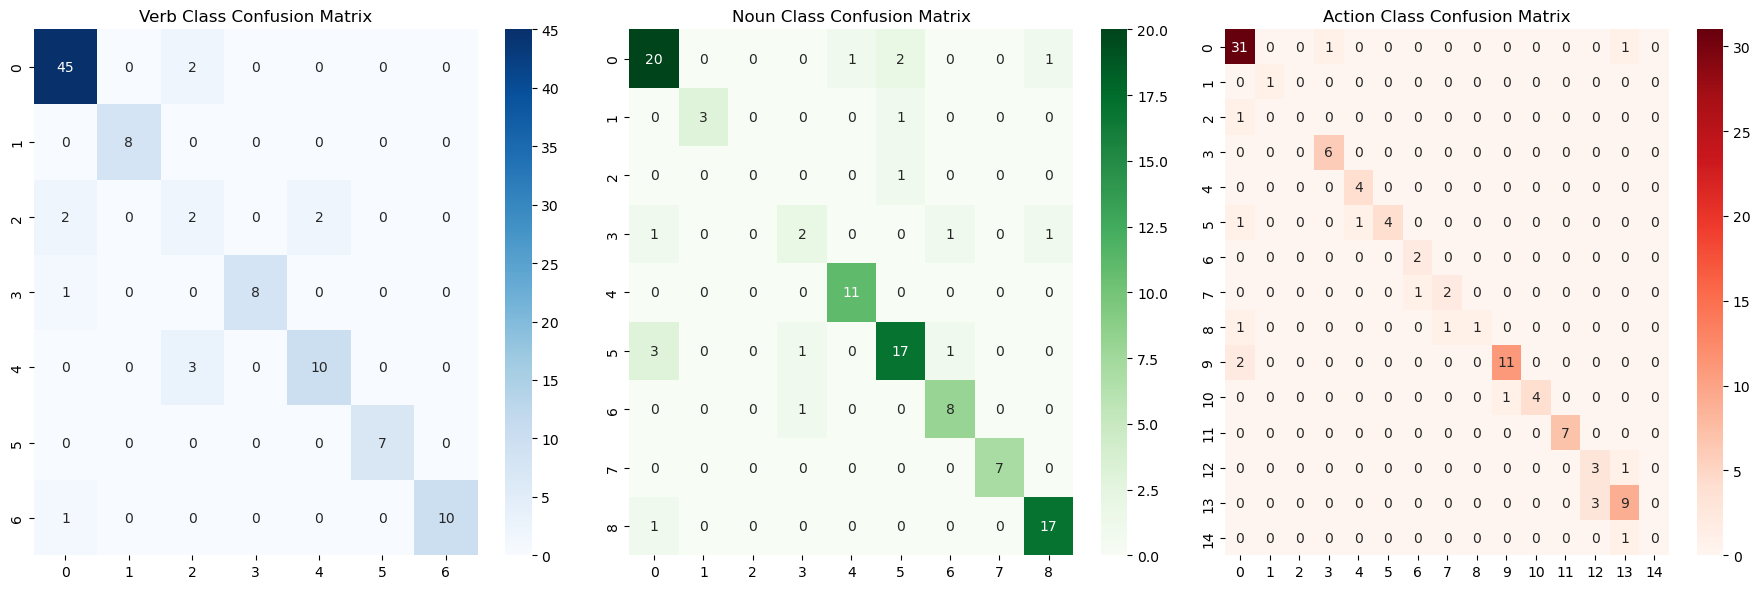

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrices for Verb, Noun, and Action
conf_matrix_verb = confusion_matrix(y_verb_val.cpu().numpy(), val_verb_preds)
conf_matrix_noun = confusion_matrix(y_noun_val.cpu().numpy(), val_noun_preds)
conf_matrix_action = confusion_matrix(y_action_val.cpu().numpy(), val_action_preds)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(conf_matrix_verb, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Verb Class Confusion Matrix")
sns.heatmap(conf_matrix_noun, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Noun Class Confusion Matrix")
sns.heatmap(conf_matrix_action, annot=True, fmt='d', cmap='Reds', ax=axes[2])
axes[2].set_title("Action Class Confusion Matrix")

plt.tight_layout()
plt.show()

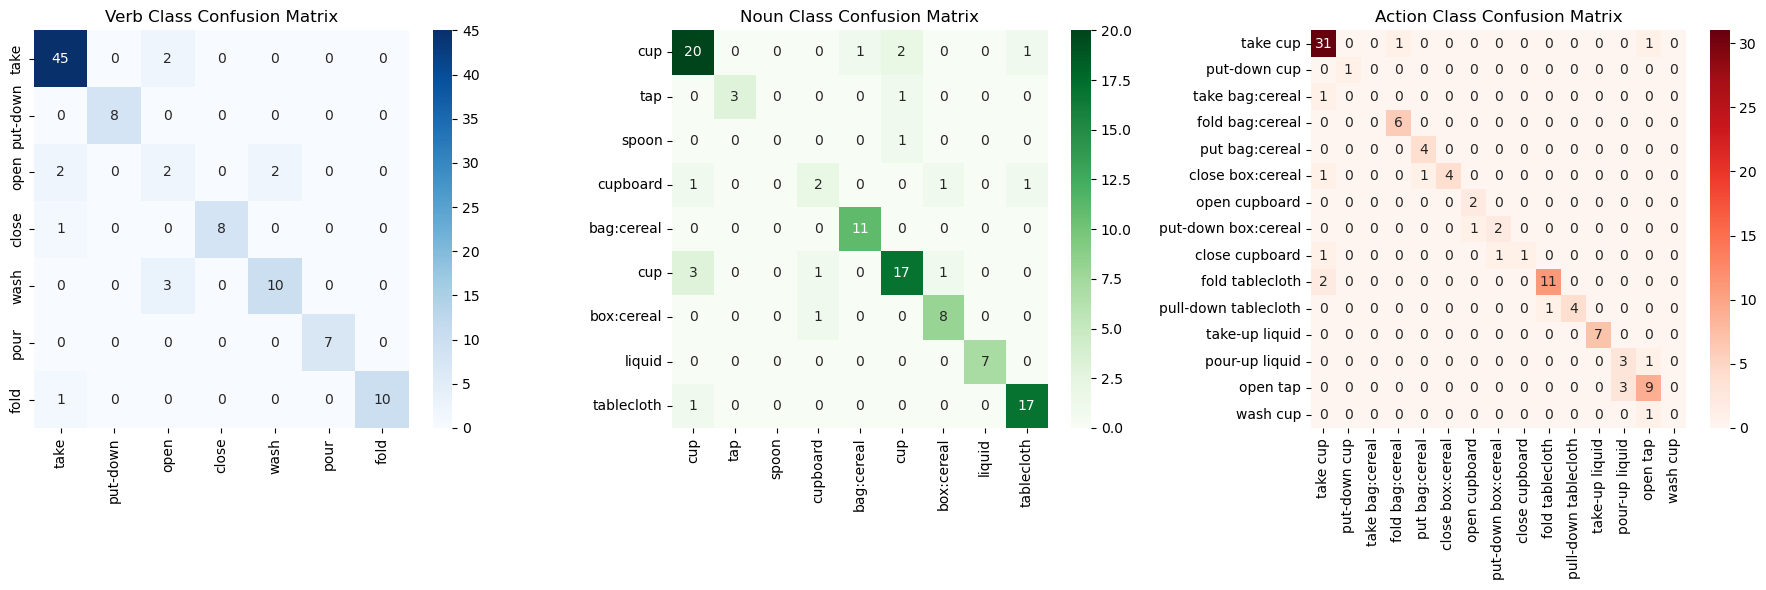

In [7]:
action_label_map = ['take cup', 'put-down cup', 'take bag:cereal', 'fold bag:cereal', 'put bag:cereal',
                    'close box:cereal', 'open cupboard', 'put-down box:cereal', 'close cupboard',
                    'fold tablecloth', 'pull-down tablecloth', 'take-up liquid', 'pour-up liquid', 'open tap','wash cup']
verb_label_map = ['take', 'put-down', 'open', 'close', 'wash','pour','fold']
noun_label_map = ['cup', 'tap', 'spoon', 'cupboard', 'bag:cereal', 'cup', 'box:cereal', 'liquid','tablecloth']


# Confusion Matrices for Verb, Noun, and Action
conf_matrix_verb = confusion_matrix(y_verb_val.cpu().numpy(), val_verb_preds)
conf_matrix_noun = confusion_matrix(y_noun_val.cpu().numpy(), val_noun_preds)
conf_matrix_action = confusion_matrix(y_action_val.cpu().numpy(), val_action_preds)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.heatmap(conf_matrix_verb, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=verb_label_map, yticklabels=verb_label_map)
axes[0].set_title("Verb Class Confusion Matrix")
sns.heatmap(conf_matrix_noun, annot=True, fmt='d', cmap='Greens', ax=axes[1], xticklabels=noun_label_map, yticklabels=noun_label_map)
axes[1].set_title("Noun Class Confusion Matrix")
sns.heatmap(conf_matrix_action, annot=True, fmt='d', cmap='Reds', ax=axes[2], xticklabels=action_label_map, yticklabels=action_label_map)
axes[2].set_title("Action Class Confusion Matrix")

plt.tight_layout()
plt.show()

In [8]:
# Save the model
saved_model_path = "../SavedModels/best_model_VNA.pth"
torch.save(model_action.state_dict(), saved_model_path)
print(f"Model saved at: {saved_model_path}")

Model saved at: ../SavedModels/best_model_VNA.pth
